<a href="https://colab.research.google.com/github/BenW55/RockPaperScissorsAI/blob/main/rpsAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition Project Dataset

The dataset is collected by the previous code. Please save the collected data (zip file or folder) in the same directory of this code in google drive.

The dataset consists of multiple <b> 480x640x3</b> color images in 3 classes (scissors, rock and paper).


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:

## Look at the current directory
%ls

dlutils.py                    sequential_36_acc_graph.png
kerutils.py                   sequential_36_loss_graph.png
__pycache__/                  sequential_38_acc_graph.png
rpsLARGE/                     sequential_38_loss_graph.png
rps_test/                     sequential_3_acc_graph.png
sequential_16_acc_graph.png   sequential_3_loss_graph.png
sequential_16_loss_graph.png  sequential_40_acc_graph.png
sequential_1_acc_graph.png    sequential_40_loss_graph.png
sequential_1_loss_graph.png   sequential_4_acc_graph.png
sequential_32_acc_graph.png   sequential_4_loss_graph.png
sequential_32_loss_graph.png  sequential_6_acc_graph.png
sequential_33_acc_graph.png   sequential_6_loss_graph.png
sequential_33_loss_graph.png  sequential_9_acc_graph.png
sequential_34_acc_graph.png   sequential_9_loss_graph.png
sequential_34_loss_graph.png  sequential_acc_graph.png
sequential_35_acc_graph.png   sequential_loss_graph.png
sequential_35_loss_graph.png


In [9]:
## Change the current dire
#%cd 'gdrive/My Drive/CIFAR_Image_Recognition'
%cd '/content/gdrive/My Drive/projectREC/'

/content/gdrive/My Drive/projectREC


# Import Data

In [10]:
!unzip -o rps.zip # use this only when you use zip files or just skip this step

unzip:  cannot find or open rps.zip, rps.zip.zip or rps.zip.ZIP.


In [11]:
!unzip -o rps_test.zip # use this only when you use zip files or just skip this step

unzip:  cannot find or open rps_test.zip, rps_test.zip.zip or rps_test.zip.ZIP.


In [13]:
import cv2
import glob
import numpy as np

X_scissor = np.asarray([cv2.imread(file) for file in glob.glob('rpsLARGE/scissors/*.jpg')])
y_scissor = np.zeros(X_scissor.shape[0])
X_rock = np.asarray([cv2.imread(file) for file in glob.glob('rpsLARGE/rock/*.jpg')])
y_rock = np.zeros(X_rock.shape[0]) + 1
X_paper = np.asarray([cv2.imread(file) for file in glob.glob('rpsLARGE/paper/*.jpg')])
y_paper = np.zeros(X_paper.shape[0]) + 2

X_all = np.concatenate((X_scissor, X_rock, X_paper), axis=0)
y_all = np.concatenate((y_scissor, y_rock, y_paper), axis=0)



In [14]:
X_scissor = np.asarray([cv2.imread(file) for file in glob.glob('rps_test/scissors/*.jpg')])
y_scissor = np.zeros(X_scissor.shape[0])
X_rock = np.asarray([cv2.imread(file) for file in glob.glob('rps_test/rock/*.jpg')])
y_rock = np.zeros(X_rock.shape[0]) + 1
X_paper = np.asarray([cv2.imread(file) for file in glob.glob('rps_test/paper/*.jpg')])
y_paper = np.zeros(X_paper.shape[0]) + 2

X_test = np.concatenate((X_scissor, X_rock, X_paper), axis=0)
y_test = np.concatenate((y_scissor, y_rock, y_paper), axis=0)

print(X_test.shape)
print(y_test.shape)

(72, 480, 640, 3)
(72,)


In [15]:
# only needed when you want to take random samples of training data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)

(482, 480, 640, 3)
(121, 480, 640, 3)


# Import Packages

In [16]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
# from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.layers.noise import GaussianNoise
#from keras.layers.advanced_activations import SReLU
#from keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
import os, sys, time, datetime, fnmatch
import numpy as np
import dlutils
import kerutils
from dlutils import *
from kerutils import *

Define classes

In [17]:
nb_classes = 3
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}

Loading Training and test data

The original data of each image is a 480x640x3 matrix of integers from 0 to 255. We need to scale it down to floats in the unit interval

In [18]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

As usual, we must convert the y_train and y_test vectors to one-hot format:<br>
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]<br>

In [19]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Let's also write two small utilities for drawing samples of images, so we can inspect our results visually.

In [20]:
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(480,640,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

Let's draw an image in X_train for example

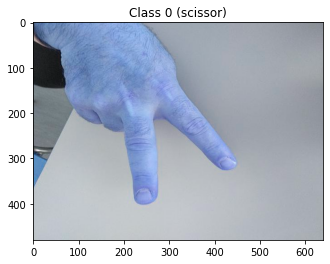

In [21]:
draw_img(0)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

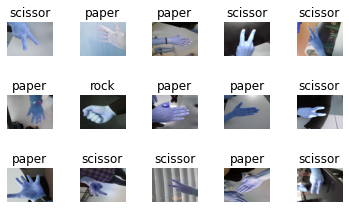

In [22]:
draw_sample(X_train, y_train, 0,3,5)

# Building Neural Network for the image set

The input layer would have to be of size 480x640x3. If we add a hidden layer with the same size, we'll end up with 9 milion synapses on the first floor. Adding one more layer of such size will take us to billions of synapses, which is of course impractical.<br>
Deep learning frameworks have come up with special types of designated layers for processing images. Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than pixels in a far away region of the image.<br>
We will start with a small Keras model which combines a well thought mix of <b>Convolution2D</b>, <b>Maxpooling2D</b> and Dense layers.<br>


We will use two types of training:<br>
<b>Standard training</b>: the usual Keras fit method<br>



# Let's Train Model 

Try another architecture

In [23]:
nb_epoch = 200
batch_size = 64

model1 = Sequential()

model1.add(Convolution2D(12, 5, 5, input_shape=(480, 640, 3), activation='relu', kernel_initializer = 'he_normal')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2), padding = 'same')) # add parameters

model1.add(Convolution2D(25, 5, 5, activation='relu', kernel_initializer = 'he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2),padding = 'same'))

model1.add(Convolution2D(35, 3, 3, activation='relu', kernel_initializer = 'he_normal'))
model1.add(MaxPooling2D(pool_size=(2, 2),padding = 'same'))

# model1.add(Convolution2D(35, 2, 1, activation='relu'))
# model1.add(MaxPooling2D(pool_size=(2, 2),padding = 'same'))

model1.add(Flatten())

HIDDEN_LAYERS= [32, 16]

for hl in HIDDEN_LAYERS:
  model1.add(Dense(hl, activation='relu', kernel_initializer = 'he_normal')) # add parameters and activation function
  #model1.add(Dropout(0.2))

model1.add(Dense(nb_classes, activation='softmax')) # activation function

# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)

# save the model if it's needed
# print('Saving model1 to the file "model_1.h5"')
# model1.save("model_1.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 128, 12)       912       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 64, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 12, 25)         7525      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 6, 25)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 2, 35)          7910      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 35)         0

In [24]:
def show_scores1(model, h, X_train, Y_train, X_test, Y_test):
    loss, acc = model.evaluate(X_train, Y_train, verbose=0)
    print ("Training: accuracy   = %.6f loss = %.6f" % (acc, loss))
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print ("Validation: accuracy = %.6f loss = %.6f" % (acc, loss))
    if 'val_acc' in h.history:
        print ("Over fitting score   = %.6f" % over_fitting_score(h))
        print ("Under fitting score  = %.6f" % under_fitting_score(h))
    print ("Params count:", model.count_params())
    print ("stop epoch =", max(h.epoch))
    print ("nb_epoch =", h.params['epochs'])
    #print ("batch_size =", h.params['batch_size'])
    #print ("nb_sample =", h.params['samples'])
    view_acc1(h)
    id = model.name[-1]
    plt.savefig(model.name + '_acc_graph.png')
    plt.show()
    view_loss(h)
    plt.savefig(model.name + '_loss_graph.png')
    plt.show()


In [25]:
def view_acc1(h):
    # Accuracy history graph
    plt.plot(h.history['accuracy'])
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)


Training: accuracy   = 1.000000 loss = 0.000351
Validation: accuracy = 0.652893 loss = 2.715281
Params count: 18078
stop epoch = 199
nb_epoch = 200


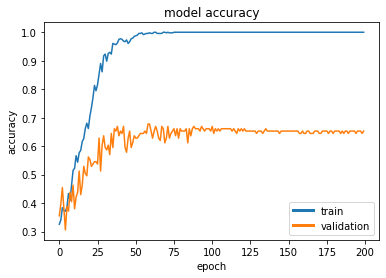

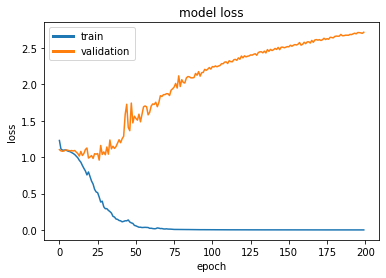

In [26]:
show_scores1(model1, h, X_train, Y_train, X_test, Y_test)

In [27]:
# model1 = load_model("model_1.h5")

In [28]:
loss, accuracy = model1.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Training: accuracy = 1.000000  ;  loss = 0.000351
Validation: accuracy1 = 0.652893  ;  loss1 = 2.715281


# Inspecting Output

Neverthelss, befor we search for a new model, let's take a quick look on some of the cases that our model1 missed. It may give us hints on the strengths an weaknesses of NN models, and what we can expect from these artificial models.<br>
The predict_classes method is helpful for getting a vector (y_pred) of the predicted classes of model1. We should compare y_pred to the expected true classes y_test in order to get the false cases:

In [29]:
predict_x=model1.predict(X_test) 
y_pred =np.argmax(predict_x,axis=1)
true_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

4/4 [==============================] - 1s 80ms/step
Number of true predictions:  79
Number of false predictions: 42


Let's see images we can recognize

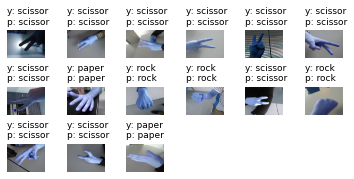

In [30]:
for i,(x,y,p) in enumerate(true_preds[0:15]):
    plt.subplot(4, 6, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

Let's see iamges we can not recognize.

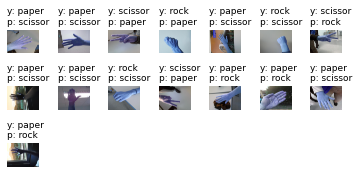

In [31]:
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(4, 7, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()